In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

In [0]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [0]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [5]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

In [0]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [9]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

  
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)  
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

W0701 07:25:05.777123 140366832105344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 07:25:05.828221 140366832105344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 07:25:05.840282 140366832105344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0701 07:25:05.907450 140366832105344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 07:25:05.909922

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [24]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks, steps_per_epoch=x_train.shape[0]//batch_size)


Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.001
1562/1562 [==============================] - 86s 55ms/step - loss: 0.8553 - acc: 0.7619 - val_loss: 1.1289 - val_acc: 0.6957

Epoch 00001: val_acc improved from 0.69010 to 0.69570, saving model to /content/saved_models/cifar10_ResNet20v1_model.001.h5
Epoch 2/50
Learning rate:  0.001
1562/1562 [==============================] - 91s 58ms/step - loss: 0.8174 - acc: 0.7761 - val_loss: 0.8840 - val_acc: 0.7616

Epoch 00002: val_acc improved from 0.69570 to 0.76160, saving model to /content/saved_models/cifar10_ResNet20v1_model.002.h5
Epoch 3/50
Learning rate:  0.001
1562/1562 [==============================] - 94s 60ms/step - loss: 0.7835 - acc: 0.7883 - val_loss: 0.8849 - val_acc: 0.7565

Epoch 00003: val_acc did not improve from 0.76160
Epoch 4/50
Learning rate:  0.001
1562/1562 [==============================] - 91s 59ms/step - loss: 0.7555 - acc: 0.8000 - val_loss: 1.0319 - val_acc: 0.7289

Epoch 00004: val_acc did not 

In [25]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 346us/step
Test loss: 0.6828972926139831
Test accuracy: 0.8414


In [0]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    

# Misclassified Image

Printing all the misclassified image

W0701 13:46:08.880549 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


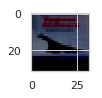

W0701 13:46:09.021221 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


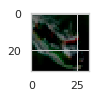

W0701 13:46:09.171201 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


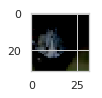

W0701 13:46:09.306022 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


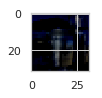

W0701 13:46:09.441468 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


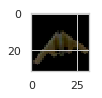

W0701 13:46:09.575076 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


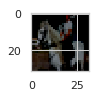

W0701 13:46:09.691611 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


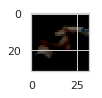

W0701 13:46:09.795612 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


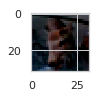

W0701 13:46:09.897729 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


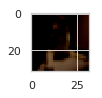

W0701 13:46:09.999589 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


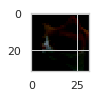

W0701 13:46:10.114675 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


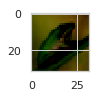

W0701 13:46:10.217776 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


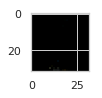

W0701 13:46:10.319385 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


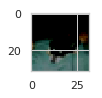

W0701 13:46:10.420260 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


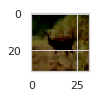

W0701 13:46:10.520542 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


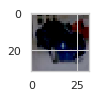

W0701 13:46:10.620729 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


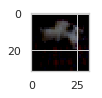

W0701 13:46:10.722246 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


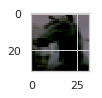

W0701 13:46:10.824452 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


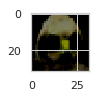

W0701 13:46:10.925401 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


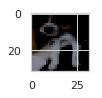

W0701 13:46:11.023032 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


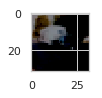

W0701 13:46:11.150806 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


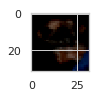

W0701 13:46:11.285077 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


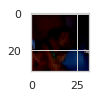

W0701 13:46:11.419207 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


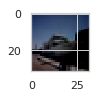

W0701 13:46:11.553604 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


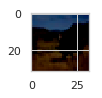

W0701 13:46:11.689642 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


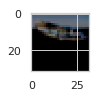

W0701 13:46:11.831652 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


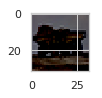

W0701 13:46:11.968222 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


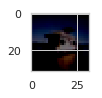

W0701 13:46:12.103694 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


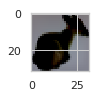

W0701 13:46:12.257950 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


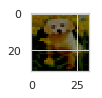

W0701 13:46:12.396429 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


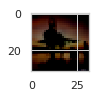

W0701 13:46:12.534041 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


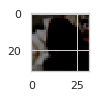

W0701 13:46:12.676307 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


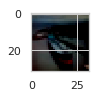

W0701 13:46:12.819068 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


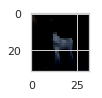

W0701 13:46:12.977455 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


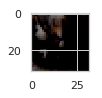

W0701 13:46:13.117682 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


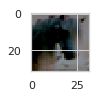

W0701 13:46:13.273263 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


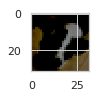

W0701 13:46:13.411772 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


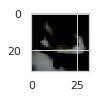

W0701 13:46:13.557754 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


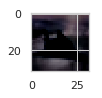

W0701 13:46:13.699334 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


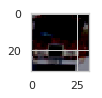

W0701 13:46:13.838551 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


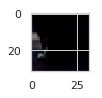

W0701 13:46:13.977121 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


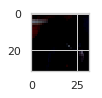

W0701 13:46:14.113977 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


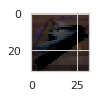

W0701 13:46:14.266570 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


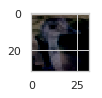

W0701 13:46:14.412286 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


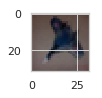

W0701 13:46:14.552128 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


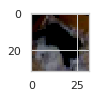

W0701 13:46:14.697506 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


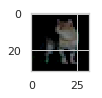

W0701 13:46:14.835300 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


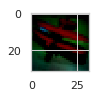

W0701 13:46:14.973645 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


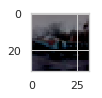

W0701 13:46:15.109697 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


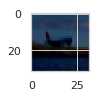

W0701 13:46:15.270533 140366832105344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


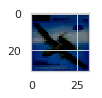

In [151]:
from matplotlib import pyplot as plt
for i in mis_class[:50]:
    plt.figure(figsize=(1,1))
    plt.imshow(x_test[i], interpolation='nearest')
    plt.show()

# Grad-Cam

In [0]:
preds = model.predict(x_test)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]


In [0]:
last_conv_layer = model.get_layer("conv2d_21")

In [0]:
import keras.backend as K
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x_test])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [85]:
from google.colab import files
files.upload()

Saving frog.png to frog.png


{'frog.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00 \x00\x00\x00 \x08\x02\x00\x00\x00\xfc\x18\xed\xa3\x00\x00\x0csIDATx^c\xb4\xb6\xb3\xff\xf0\xe1\x1d;\xd3?!\xb6\xffr\xc2\\\xa2B\xdc"\x02<l\xcc\xac,\xec\x9c\x0c\xcc,\xef\xde\x7f\xf8\xf5\xe7\xbf\xa0\x00?\xd3\xdf\xdf?\x7f\xfe\xfc\xf1\xe3\x07\x07\'\xc7_\x86\xbf\xdf\xbe\x7f\xe1\x17\xe0c\xf8\xff\xf7\xd7\xcf_\xcc\x0c\xac\xcc\xcc\xcc\xbc<<\xdc\xdc\xdc\xac\xac\x1c\xdf\x7f\xfe\xfa\xcf\xc8\xc4\xc0\xc4\x02\x94\xfa\xf3\x9f\x91\xe5\xea\xb5\xab\x1f\xde\xbc\x11\xe2``\x14\xe6\x10\xf9\xcb\xcb\xc8)\xf6\xf5\xdf\xbb/\x7f\xff\xffgd\xfb\xf6\xe3\xd7\xb7\xef?\x7f\xff\xfd\xf7\x86\x99\x91\x83\xe5\xff\x9f?\xff\x98\x99X\xd8\xd9\xd9\xbf\xfd\xf8\xfa\xe7\xdf/\xc6\x1f\xc2L\xcc\x0c@k9Y8\xbe\xfc\xfc\xf5\xee\xef\x1f..nF&VFfV\x06&\xa6o?~\xff\xf9\xfd\x9b\x99\x85\x9d\x85\x93\x85\x91\x81\x9dA^\x98CA\x9c_LT\x88\x13\xa8\x88\x91\xf1;\xd0\xad\xbf\x7f\xfegdd\xe3\xe4d\xf8\xf3\xff\xff\xbf\x9f\xfcB\\\x7f~\xffgc\xe5\xfc\xfb\x97\x81\x99\x8d\xfd\xe7/\xa0\x01\x8c\\l\xec,\xdc\x9

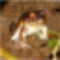

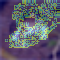

-1

In [160]:
import cv2
from google.colab.patches import cv2_imshow
img_path = "frog.png"
img = cv2.imread(img_path)
img = cv2.resize(img, (60,60))
heatmap = cv2.resize(heatmap, (60, 60))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
cv2_imshow(img)
cv2_imshow(superimposed_img)
cv2.waitKey(0)


